In [1]:
from tqdm.notebook import tqdm
from importlib.resources import files

import numpy as np
import pandas as pd

from shapely import Polygon

from astropy.wcs import WCS
from astropy.time import Time

In [2]:
import galsim
import euclidlike

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mpl_Polygon
from matplotlib.collections import PatchCollection
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

#### Load Obseq

In [4]:
obseq_path = files("euclidlike_imsim.data").joinpath("euclid_obseq.pkl")
obseq = pd.read_pickle(obseq_path)

#### Get pointings from obs ID

In [5]:
obs_id = 42

In [6]:
ind = obseq[obseq["obs_id"] == obs_id].index
pointings = np.unique(ind.get_level_values("visit").to_numpy())
print(pointings)

[164 165 166 167]


#### Get CCDs footprints

In [7]:
all_exp_foot = {}
for point in tqdm(pointings):
    all_exp_foot[point] = {}
    for ccd_n in range(36):
        h = euclidlike.getWCS(
            world_pos=galsim.CelestialCoord(
                ra=obseq.loc[point, "VIS_LONG"]["ra"]*galsim.degrees,
                dec=obseq.loc[point, "VIS_LONG"]["dec"]*galsim.degrees,
            ),
            PA=(obseq.loc[point, "VIS_LONG"]["pa"])*galsim.degrees,
            date=Time(obseq.loc[point, "VIS_LONG"]["date_euclid"], format="mjd").datetime,
            CCDs=ccd_n,
            SAA=obseq.loc[point, "VIS_LONG"]["saa"]*galsim.degrees,
        )[ccd_n].header.header.copy()
        h["NAXIS1"] = euclidlike.n_pix_row
        h["NAXIS2"] = euclidlike.n_pix_col
        ccd_w = WCS(h)
        ccd_foot = ccd_w.calc_footprint()
        ccd_poly = Polygon(ccd_foot)
        all_exp_foot[point][ccd_n] = ccd_foot

  0%|          | 0/4 [00:00<?, ?it/s]

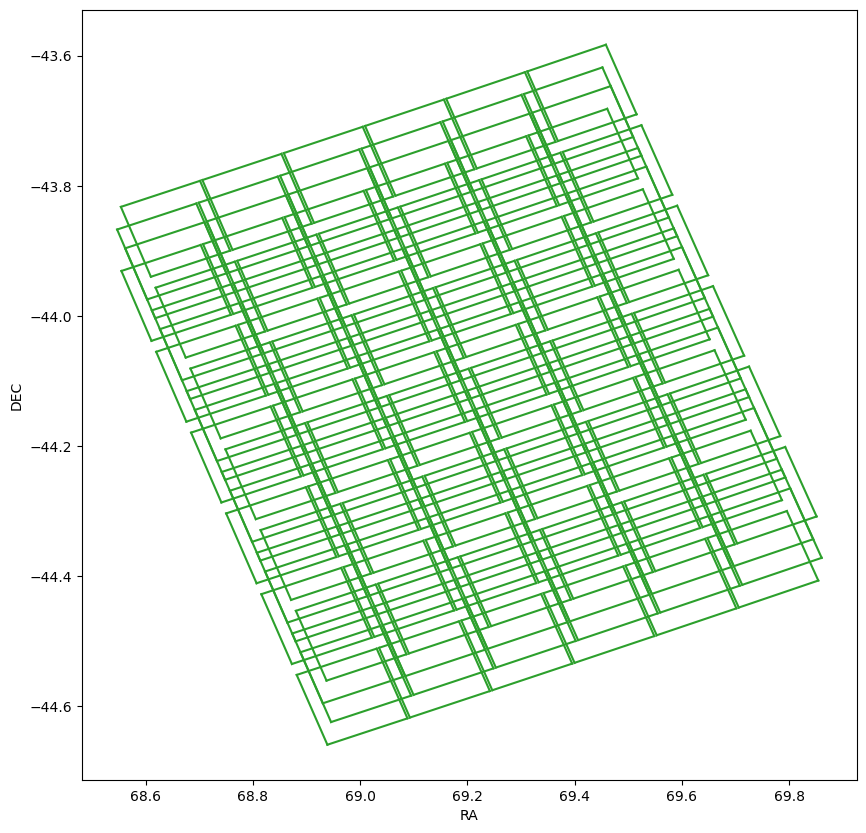

In [13]:
plt.figure(figsize=(10, 10))

for point in pointings:
    for ccd in range(36):
        foot = all_exp_foot[point][ccd].T
        plt.plot([foot[0][0], foot[0][1]], [foot[1][0], foot[1][1]], color=color[2])
        plt.plot([foot[0][1], foot[0][2]], [foot[1][1], foot[1][2]], color=color[2])
        plt.plot([foot[0][2], foot[0][3]], [foot[1][2], foot[1][3]], color=color[2])
        plt.plot([foot[0][3], foot[0][0]], [foot[1][3], foot[1][0]], color=color[2])
plt.xlabel("RA")
plt.ylabel("DEC")
xlim = plt.xlim()
ylim = plt.ylim()

Text(0, 0.5, 'DEC')

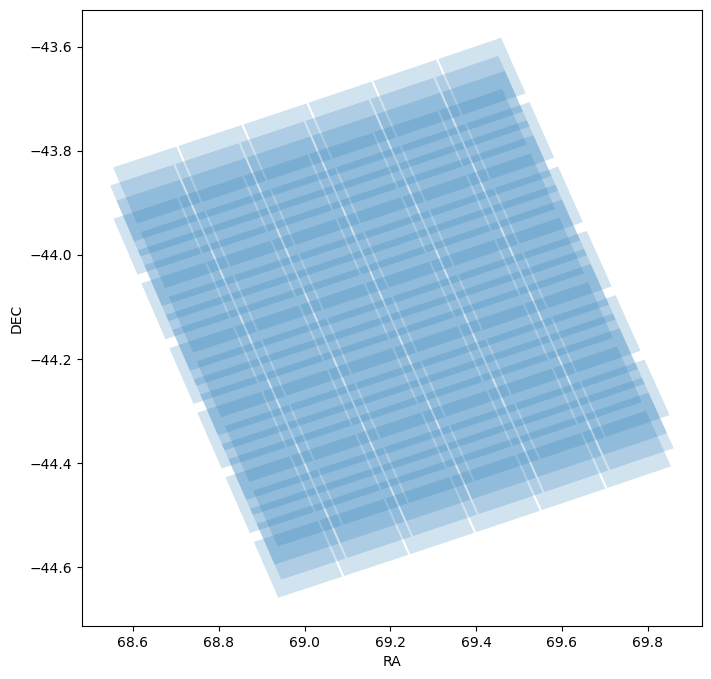

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

patches = []
for point in pointings:
    for ccd in range(36):
        foot = all_exp_foot[point][ccd]
        polygon = mpl_Polygon(foot, closed=True)
        patches.append(polygon)

p = PatchCollection(patches, alpha=0.2)
ax.add_collection(p)

plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("RA")
plt.ylabel("DEC")